# Machine Learning (second part): Intermediate report

*Write your name and your student ID below.*

In [3]:
# Modify these lines.
student_name = 'Yuki Tsushima'
student_id = '20M31065'

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following four problems, and submit the notebook file (`.ipynb`) on OCW. **We do not accept a report in other formats (e.g., Word, PDF, HTML)**. You can use any deep learning library for completing this report. Write a code at the specified cell in the notebook. You can add more cells if necessary. Submit this report even if you cannot solve all problems.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearning/blob/master/notebook/binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearning/blob/master/notebook/mnist.ipynb)

*Please accept that your report may be shared among students who take this course.*

## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the performance of the model on the test set in accuracy.

One can use the same code shown in the lecture. Write a code here and show the output.

In [62]:
# Get MNIST dataset and devide it into train and test (same as mnist.ipynb)
import gzip
import sys
import struct
import urllib.request
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )

In [14]:
# Uncomment these lines when you use TensorBoard.
#%load_ext tensorboard
#%tensorboard --logdir ./runs/

In [63]:
# numpy array -> pytorch tensor (same as mnist.ipynb)
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

In [64]:
# Main part CNN (same as mnist.ipynb)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np

device = torch.device("cuda:0")


class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),    
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

writer = SummaryWriter(comment="CNN")
for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Record loss and accuracy values on the training and test sets.
    writer.add_scalars('loss', {'train': train_loss, 'test': test_loss}, t)
    writer.add_scalars('accuracy', {'train': train_correct, 'test': test_correct}, t)

    # Report progress (comment out the following line when you use TensorBoard).
    if (t % 10 == 0 or t == 99):
        print('#{}: loss_test={:.4f}, loss_train={:.4f}, acc_test={:.4f}, acc_train={:.4f}'.format(
            t,
            test_loss,
            train_loss,
            test_correct,
            train_correct
        ))

writer.close()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten()
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=256, out_features=10, bias=True)
)
#0: loss_test=0.0181, loss_train=0.0090, acc_test=0.1187, acc_train=0.1076
#10: loss_test=0.0174, loss_train=0.0087, acc_test=0.4592, acc_train=0.2366
#20: loss_test=0.0110, loss_train=0.0065, acc_test=0.6791, acc_train=0.4325
#30: loss_test=0.0063, loss_train=0.0045, acc_test=0.7975, acc_train=0.6128
#40: loss_test=0.0045, loss_train=0.0035, acc_test=0.8485, acc_train=0.7017
#50: loss_test=0.0036, loss_train=0.00

## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

In [65]:
confusion = np.zeros((10,10),dtype="int32")
eval_loader = DataLoader(test_set, batch_size=len(test_set))
for _,(x,y) in enumerate(eval_loader):
    x = x.to(device)
    test_pred = model(x)
    _, predicted = torch.max(test_pred.data, 1)
    for i in range(len(y)):
        confusion[y[i].item()][predicted[i].item()] += 1
    print(confusion)


[[ 929    0    9    2    2    5   19    6    8    0]
 [   0 1088    8    9    2    3    5    4   16    0]
 [  11   13  870   31   12    4   13   32   40    6]
 [   4    2   30  876    2   41    4   11   25   15]
 [   1    6    7    1  807    4   21    4   18  113]
 [  25    8    7   46    9  721   21    7   38   10]
 [  15    5   15    0   18   19  878    0    7    1]
 [   5   19   42    7    5    4    0  861   17   68]
 [  15   11   15   30   14   39   20   17  788   25]
 [  12    8   11   15   81   10    6   52   20  794]]


## 3. Top-3 easy and confusing examples

Show the top three easy and three confusing, respectively, images where the model recognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n = \hat{y}_n$ (for easy three examples) and $y_n \neq \hat{y}_n$ (for confusing three examples).

For each example, please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$ together with the image $x_n$. This is an example of an output for an image (you need this kind of outputs for top-three easy and top-three confusing images, in other words, for six images in total).

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

In [81]:
# Search best3 and worst3
eval_loader = DataLoader(test_set, batch_size=len(test_set))
easy1_id = 0;   easy2_id = 0;   easy3_id = 0
easy1_pr =-1.0; easy2_pr =-1.0; easy3_pr =-1.0
conf1_id = 0;   conf2_id = 0;   conf3_id = 0
conf1_pr =-1.0; conf2_pr =-1.0; conf3_pr =-1.0
for _,(x,y) in enumerate(eval_loader):
    x = x.to(device)
    test_pred = model(x)
    _, predicted = torch.max(test_pred.data, 1)
    for n in range(len(y)):
        true_label = y[n].item()
        predicted_label = predicted[n].item()
        predicted_prob  = test_pred[n][predicted_label].item()
        if true_label == predicted_label:
            # correct
            if predicted_prob > easy1_pr:
                easy3_id = easy2_id; easy3_pr = easy2_pr
                easy2_id = easy1_id; easy2_pr = easy1_pr
                easy1_id = n;        easy1_pr = predicted_prob
            elif predicted_prob > easy2_pr:
                easy3_id = easy2_id; easy3_pr = easy2_pr
                easy2_id = n;        easy2_pr = predicted_prob
            elif predicted_prob > easy3_pr:
                easy3_id = n;        easy3_pr = predicted_prob
        else:
            if predicted_prob > conf1_pr:
                conf3_id = conf2_id; conf3_pr = conf2_pr
                conf2_id = conf1_id; conf2_pr = conf1_pr
                conf1_id = n;        conf1_pr = predicted_prob
            elif predicted_prob > conf2_pr:
                conf3_id = conf2_id; conf3_pr = conf2_pr
                conf2_id = n;        conf2_pr = predicted_prob
            elif predicted_prob > conf3_pr:
                conf3_id = n;        conf3_pr = predicted_prob
    #save other data
    easy1_label = y[easy1_id].item(); easy2_label = y[easy2_id].item(); easy3_label = y[easy3_id].item()
    conf1_predicted_label = predicted[conf1_id].item(); conf2_predicted_label = predicted[conf2_id].item(); conf3_predicted_label = predicted[conf3_id].item()
    conf1_true_label = y[conf1_id].item(); conf2_true_label = y[conf2_id].item(); conf3_true_label = y[conf3_id].item()
    conf1_true_pr = test_pred[conf1_id][conf1_true_label].item();
    conf2_true_pr = test_pred[conf2_id][conf2_true_label].item();
    conf3_true_pr = test_pred[conf3_id][conf3_true_label].item();

In [82]:
# Prepare plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = np.load('mnist.npz')

1st easiest No.8791 True digit: 7 (20.2992)


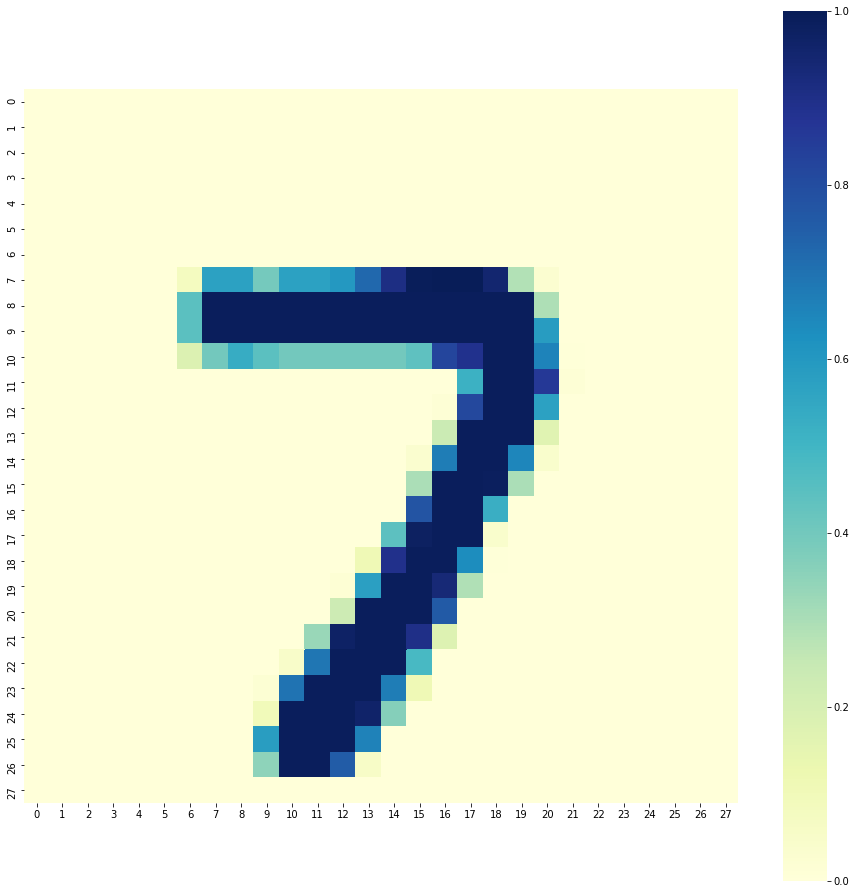

2nd easiest No.7062 True digit: 0 (19.0565)


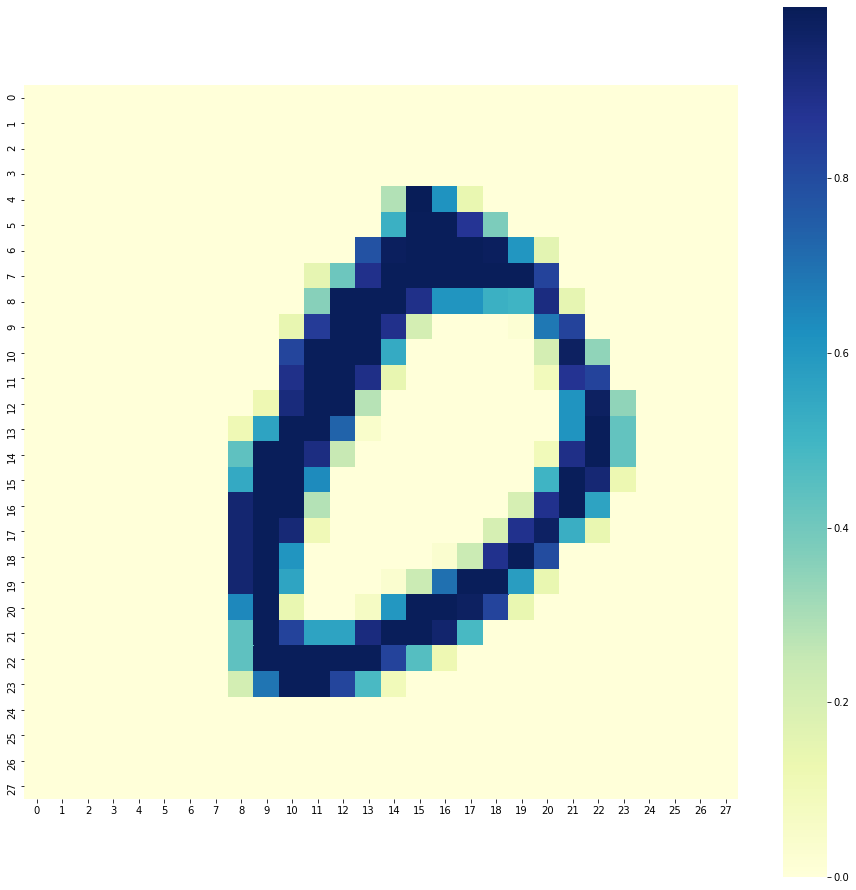

3rd easiest No.440 True digit: 0 (18.9957)


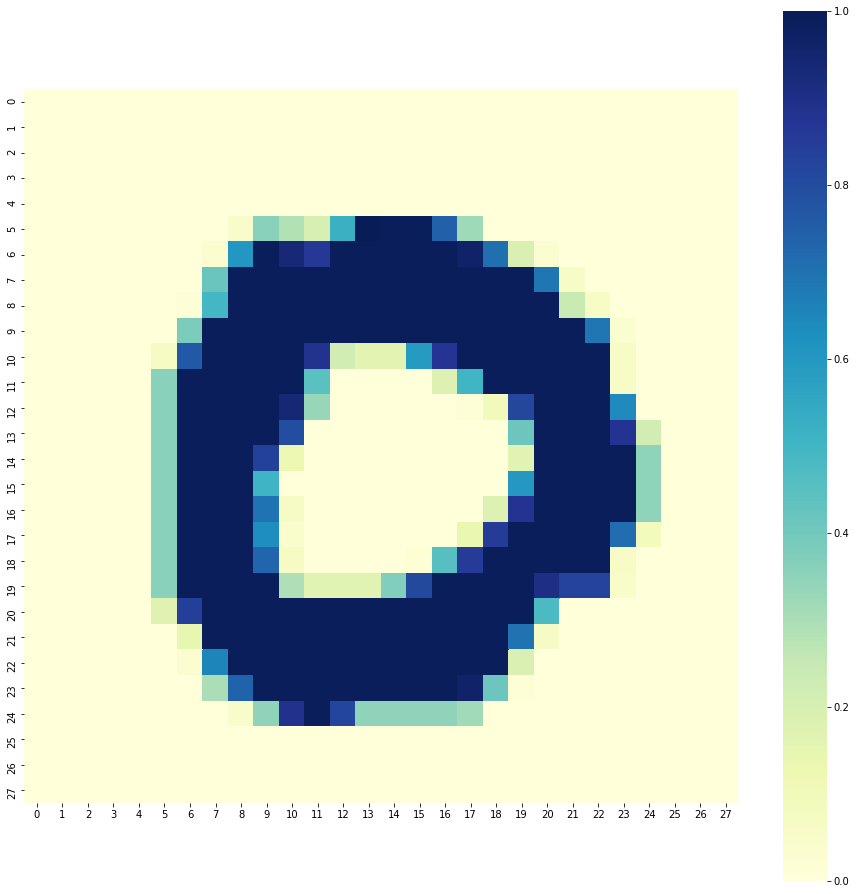

1st confusing No.947 True digit: 8 (4.9021); prediction: 9 (14.0524)


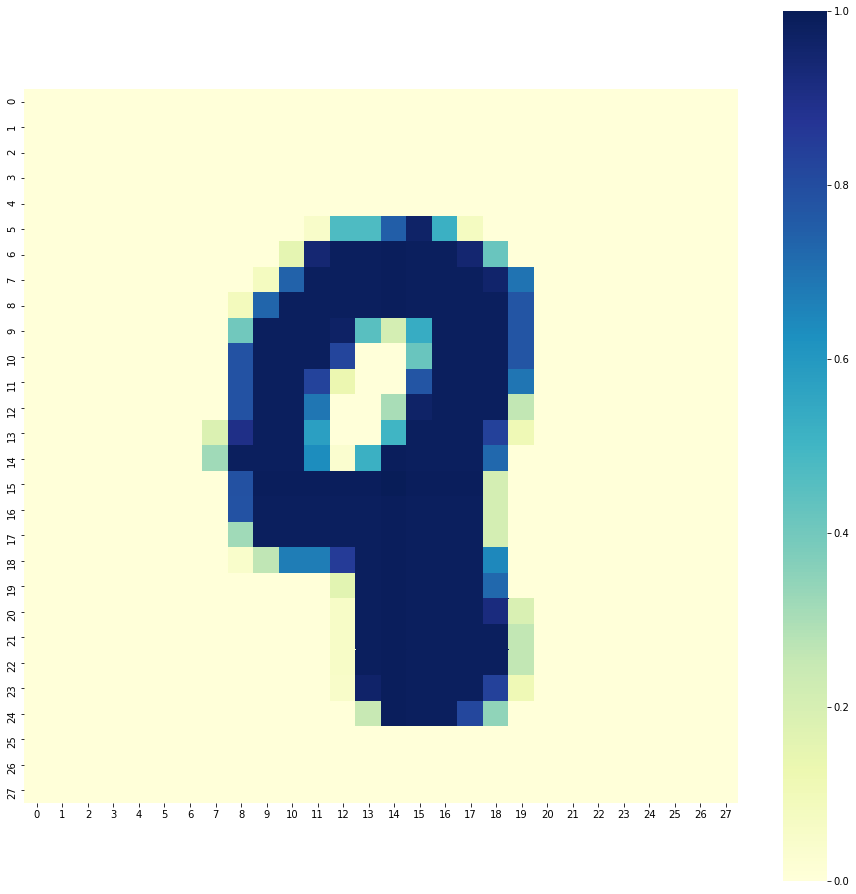

2nd confusing No.8680 True digit: 9 (13.2341); prediction: 7 (13.4208)


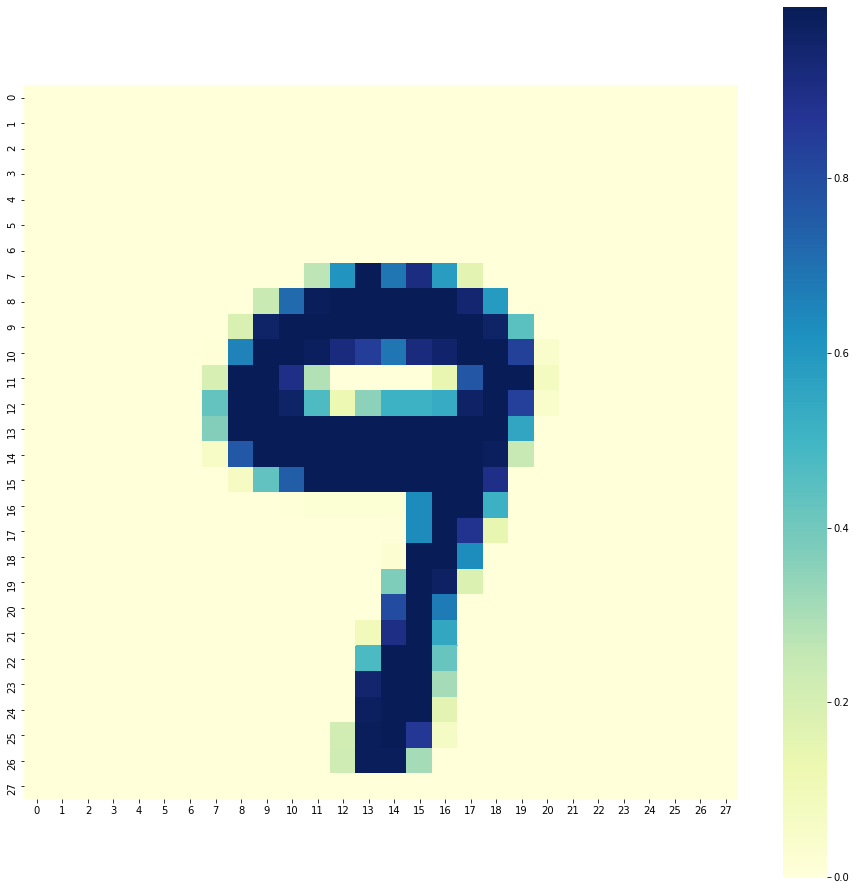

3rd confusing No.6242 True digit: 7 (11.2089); prediction: 9 (12.0660)


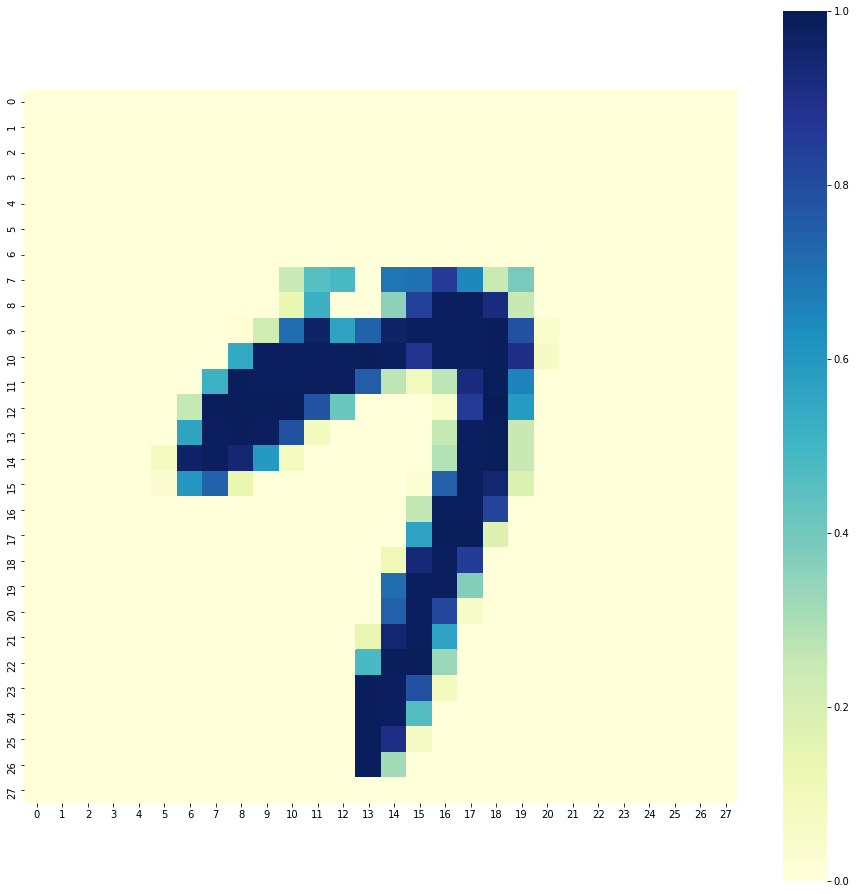

In [87]:
# Show probability and images

image = data['test_x'][easy1_id]
label = data['test_y'][easy1_id]
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=False, square=True, cmap="YlGnBu")
print("1st easiest No.{} True digit: {} ({:.4f})".format(easy1_id,easy1_label,easy1_pr))
plt.show()
image = data['test_x'][easy2_id]
label = data['test_y'][easy2_id]
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=False, square=True, cmap="YlGnBu")
print("2nd easiest No.{} True digit: {} ({:.4f})".format(easy2_id,easy2_label,easy2_pr))
plt.show()
image = data['test_x'][easy3_id]
label = data['test_y'][easy3_id]
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=False, square=True, cmap="YlGnBu")
print("3rd easiest No.{} True digit: {} ({:.4f})".format(easy3_id,easy3_label,easy3_pr))
plt.show()
image = data['test_x'][conf1_id]
label = data['test_y'][conf1_id]
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=False, square=True, cmap="YlGnBu")
print("1st confusing No.{} True digit: {} ({:.4f}); prediction: {} ({:.4f})".format(conf1_id,conf1_true_label, conf1_true_pr,conf1_predicted_label,conf1_pr))
plt.show()
image = data['test_x'][conf2_id]
label = data['test_y'][conf2_id]
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=False, square=True, cmap="YlGnBu")
print("2nd confusing No.{} True digit: {} ({:.4f}); prediction: {} ({:.4f})".format(conf2_id,conf2_true_label, conf2_true_pr,conf2_predicted_label,conf2_pr))
plt.show()
image = data['test_x'][conf3_id]
label = data['test_y'][conf3_id]
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=False, square=True, cmap="YlGnBu")
print("3rd confusing No.{} True digit: {} ({:.4f}); prediction: {} ({:.4f})".format(conf3_id,conf3_true_label, conf3_true_pr,conf3_predicted_label,conf3_pr))
plt.show()

## 4. Recognize your handwritten digits

Prepare three image files each of which presents a digit written by you. For each image, apply the MNIST model you trained, and show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ (10-dimensional vector) for all possible digits as well as the image itself.

Please refer to [this notebook](https://colab.research.google.com/notebooks/io.ipynb) about how to upload a file to Google Colaboratory.

### Image #1

Write the code to show the image #1 here.

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.

### Image #2

Write the code to show the image #2 here.

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.


### Image #3

Write the code to show the image #3 here.

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.